In [26]:
!python --version
#%pip install numpy pandas matplotlib seaborn scikit-learn statsmodels mesa gpboost tqdm


Python 3.8.18


In [50]:
import os
import pandas as pd
import numpy as np
import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib
from scipy import stats
import statsmodels.api as sm
from functools import reduce
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import gpboost as gpb
from scipy.stats import ttest_ind
from scipy.stats import spearmanr
from tqdm import tqdm

plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = "Helvetica"

## Preparation

In [81]:
pilot_df = pd.read_csv("./data/pilot.csv", index_col=0)


In [82]:
pilot_df_participant = (
    pilot_df[['participantId', 'condition', 'manipulationCheck', 'residentialExperience', 'gender', 'participantAge']].drop_duplicates()
    .reset_index(drop=True)
)

In [83]:
# Limit to those who have ever searched apartments by themselves
source_pids = pilot_df_participant[lambda x: x.residentialExperience.isin([1, 2])].participantId.values
print(source_pids)

['j52x7ovk6xtp7h7' 'cq56rxkkq87fl64' '7l2jrlcnhb3t0px' 'gvlts740j5h8ebn']


In [84]:
# Choose 1st stage data
pilot_mean_df = (
    pilot_df[lambda x: (x.participantId.isin(source_pids)) & (x.phase == 1)]
    .groupby(['questionId', 'age', 'area', 'distance', 'rentTruth'])
    .agg({'estimate': 'mean'})
    .reset_index()
)

X = pilot_mean_df[["age", "area", "distance"]]
y = pilot_mean_df["estimate"]

reg = LinearRegression().fit(X, y)
pilot_mean_df["pred"] = reg.predict(X)
pilot_mean_df


,questionId,age,area,distance,rentTruth,estimate,pred
0,0,18,7.3,5,5.9,8.175,9.347297
1,1,44,8.7,2,6.0,7.000,6.616650
2,2,19,21.3,5,14.5,16.475,15.915222
3,3,46,18.4,4,8.5,9.225,10.874651
4,4,33,13.0,5,7.5,9.725,10.017199
5,5,37,10.5,6,7.0,8.875,8.213915
6,6,60,23.3,1,11.7,10.225,11.468400
7,7,11,13.3,7,9.1,12.150,13.069251
8,8,36,19.0,7,11.8,12.075,12.365754
9,9,24,15.8,4,8.7,12.800,12.650866


## Simulations  

In [32]:
def gradient_descent_update(x_sample, y_sample, beta, learning_rate):
    """
    Perform one step of gradient descent using one sample

    :param x_sample: single feature vector
    :param y_sample: actual value for the given feature vector
    :param beta: current coefficients
    :param learning_rate: step size for update
    :return: updated coefficients
    """
    y_pred = x_sample.dot(beta)
    gradient = -2 * x_sample.T * (y_sample - y_pred)
    beta -= learning_rate * gradient
    return beta

def mean_squared_error(true_beta, estimated_beta):
    return np.mean((true_beta - estimated_beta) ** 2)

def euclidean_distance(true_beta, estimated_beta):
    return np.linalg.norm(true_beta - estimated_beta)

In [33]:
class ConformityAgent(Agent):
    def __init__(self, unique_id, model, t_birth, *, lifespan, p_learn, conformity, sensitivity):
        super().__init__(unique_id, model)
        self.beta = np.random.uniform(0, 1, size=self.model.n_dim)
        self.cum_performance = 0
        self.t_birth = t_birth
        self.lifespan = lifespan
        self.p_learn = p_learn
        self.conformity = conformity
        self.sensitivity = sensitivity

    def step(self):
        # x, y = self.model.current_x, self.model.current_y
        self.pred_y = self.model.current_x.dot(self.beta)

        # Learning from environments
        if np.random.uniform(0, 1) < self.p_learn:
            self.beta = gradient_descent_update(self.model.current_x, self.model.current_y, self.beta, self.model.learning_rate)

        # Conformity behavior (none, shallow or deep)
        if (self.conformity != "None"):
            if "Asymmetric" in self.conformity:
                tgt_agents = [agent for agent in self.model.schedule.agents if (agent != self) & (agent.t_birth < self.t_birth)]
            elif "Reciprocal" in self.conformity:
                tgt_agents = [agent for agent in self.model.schedule.agents if (agent != self)]
            if len(tgt_agents) > 0:
                tgt_agent = np.random.choice(tgt_agents)
                # tgt_agent = min([agent for agent in tgt_agents], key=lambda x: x.t_birth)
                tgt_pred_y = self.model.current_x.dot(tgt_agent.beta)
                self.pred_y += (tgt_pred_y - self.pred_y) * self.sensitivity # conform about this specific problem
                if ("Deep" in self.conformity):
                    # self.beta = gradient_descent_update(self.model.current_x, tgt_pred_y, self.beta, self.model.learning_rate)
                    self.beta += (tgt_agent.beta - self.beta) * self.sensitivity # comform about beta

        self.cum_performance += performance(self)
        self.lifespan -= 1
        if self.lifespan < 0: # pass away in lifespan years
            self.model.schedule.remove(self)

# Convenient functions
def beta_gap(agent):
    return euclidean_distance(agent.model.true_beta, agent.beta)


def performance(agent):
    return - (agent.pred_y - agent.model.current_y) ** 2

            
# Model            
class GenerationModel(Model):
    def __init__(
        self, *, 
        n_dim, # Number of dimensions of the feature space
        learning_rate, # Learning rate when learning directly about the environment
        lifespan, # Lifespan of an agent
        p_learn, # Probability of direct learning
        conformity, # Conformity Type
        sensitivity, # Sensitivity of conformity (both at shallow and deep levels)
        gen_interval, # Interbval between generations; lifespan - gen_interval defines the number of timesteps where an agent learn by themselves alone
        n_agents_per_gen, # Number of agents per generation
        seed=0
    ):
        np.random.seed(seed)
        self.schedule = RandomActivation(self)
        self.n_dim = n_dim
        self.learning_rate = learning_rate
        self.lifespan = lifespan
        self.p_learn = p_learn
        self.conformity = conformity
        self.sensitivity = sensitivity
        self.gen_interval = gen_interval
        self.n_agents_per_gen = n_agents_per_gen

        self.true_beta = np.random.uniform(0, 1, size=self.n_dim)
        # self.init_beta_center = np.random.uniform(0, 1, size=self.n_dim)
        self.datacollector = DataCollector(
            agent_reporters={"t_birth": "t_birth", "beta_gap": beta_gap, "performance": performance, "cum_performance": "cum_performance"}
        )
        self.n_agents = 0

    def step(self):
        # Generate new x and y
        self.current_x = np.random.uniform(0, 1, size=self.n_dim)
        self.current_y = self.current_x.dot(self.true_beta)

        # Create a new generation of agents
        if self.schedule.steps % self.gen_interval == 0:
            for i in range(self.n_agents_per_gen):
                a = ConformityAgent(
                    unique_id=self.n_agents,
                    model=self,
                    t_birth=self.schedule.steps,
                    # beta_init=np.random.uniform(0, 1, size=self.n_dim), 
                    # beta_init=np.random.normal(self.init_beta_center, scale=.01),
                    lifespan=self.lifespan,
                    p_learn=self.p_learn,
                    conformity=self.conformity,
                    sensitivity=self.sensitivity
                )
                self.schedule.add(a)
                self.n_agents += 1

        self.schedule.step()
        self.datacollector.collect(self)


In [34]:
def main_simulation(param, param_list):
    model_args = dict(
        n_dim=40,
        learning_rate=.05,
        lifespan=20,
        p_learn=1,
        conformity='uni-deep',
        sensitivity=.3,
        gen_interval=10,
        n_agents_per_gen=10,
        seed=1
    )
    
    res_list = []
    
    for p in tqdm(param_list):
        model_args[param] = p
        model_dict = {}
        for cond_name in ['None', 'Shallow & Reciprocal', 'Shallow & Asymmetric', 'Deep & Reciprocal', 'Deep & Asymmetric']:
            model_args['conformity'] = cond_name
            model = GenerationModel(**model_args)
            for t in range(400):
                model.step()
            model_dict[cond_name] = model
        res = {
            'model_dict': model_dict,
            'param_name': param,
            'param': param_list,
            'res_list': res_list
        }
        res_list.append(res)
    
    output = {
        'param_name': param,
        'param': param_list,
        'res_list': res_list
    }
    
    return output


In [85]:
%%time
sim_50times = main_simulation('seed', range(100))

100%|██████████| 100/100 [01:13<00:00,  1.35it/s]

CPU times: user 1min 12s, sys: 1.08 s, total: 1min 13s
Wall time: 1min 13s


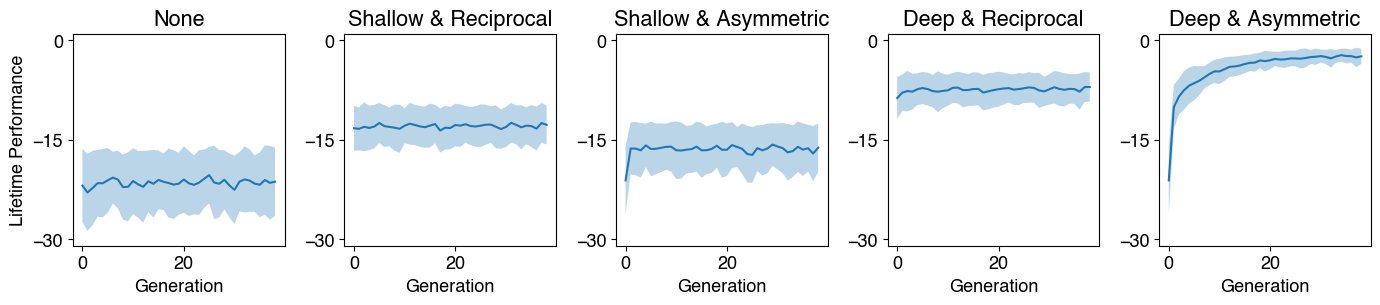

In [80]:
fig, axes = plt.subplots(1, 5, figsize=(14, 3))
for ax, (cond_name, model) in zip(axes, sim_50times['res_list'][0]['model_dict'].items()):
    ax.set_box_aspect(1)
    y = []
    for i in range(100):
        result_df = sim_50times['res_list'][i]['model_dict'][cond_name].datacollector.get_agent_vars_dataframe().reset_index()
        result_df['age'] = result_df.Step - result_df.t_birth
        cum_performance_per_gen = result_df[lambda x: x.age == 20].groupby("t_birth")['cum_performance'].mean()
        y.append(cum_performance_per_gen.values)

    d = pd.DataFrame({
        "x": cum_performance_per_gen.index / 10,
        "y": np.array(y).mean(axis=0),
        "err": np.array(y).std(axis=0)
    })
    
    # ax.scatter(x, y, label=cond_name, marker="+", alpha=.7)
    sns.lineplot(d, x="x", y="y", ax=ax, label=cond_name, legend=False)
    ax.fill_between(d.x, d.y - d.err, d.y + d.err, alpha=.3)

    ax.set_title(cond_name)
    ax.set_ylim(-31, 1)
    ax.set_yticks([0, -15, -30])
    # ax.legend(bbox_to_anchor=(1, 1), frameon=False)
    ax.set_xlabel("Generation")
    if cond_name == 'None':
        ax.set_ylabel("Lifetime Performance")
    else:
        ax.set_ylabel("")
        
plt.tight_layout()
plt.savefig("img/lifetime-performance.pdf")
plt.show()
plt.close()


In [78]:
np.array([[2,3], [5,6],[8,9]]).std(axis=1)


array([0.5, 0.5, 0.5])

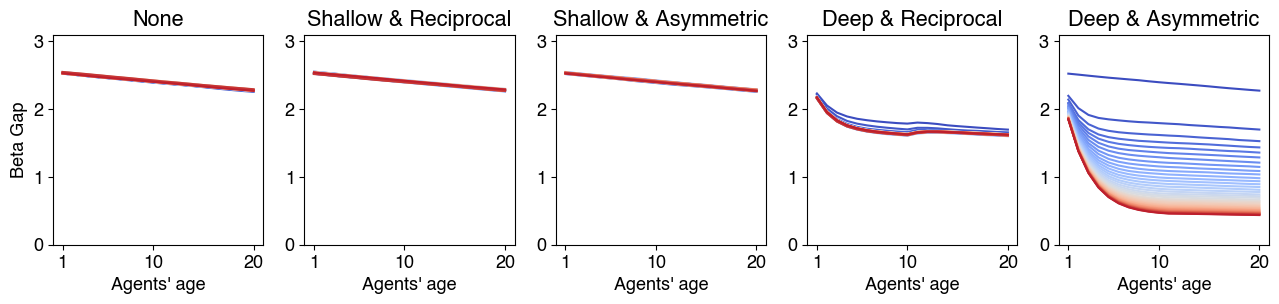

In [37]:
fig, axes = plt.subplots(1, 5, figsize=(13, 3))

cmap = plt.cm.coolwarm #Oranges
N = 39
for ax, (cond_name, model) in zip(axes, sim_50times['res_list'][0]['model_dict'].items()):
    ax.set_box_aspect(1)
    
    beta_gap_per_gen_list = []
    for i in range(100):
        result_df = sim_50times['res_list'][i]['model_dict'][cond_name].datacollector.get_agent_vars_dataframe().reset_index()
        result_df['age'] = result_df.Step - result_df.t_birth
        beta_gap_per_gen_list.append(result_df.groupby(['t_birth', 'age'])['beta_gap'].mean().unstack())
    
    beta_gap_per_gen = pd.concat(beta_gap_per_gen_list).groupby(level=0).mean()  # calculate mean of 100 simulations
    
    for t_birth, data in beta_gap_per_gen.head(N).iterrows():
        ax.plot(data, color=cmap(t_birth/N/10))
        
    ax.set_ylim(0, 3.1)
    ax.set_xticks([1, 10, 20])
    ax.set_title(cond_name)
    ax.set_xlabel("Agents' age")
    if cond_name == 'None':
        ax.set_ylabel('Beta Gap')

plt.tight_layout()
plt.savefig("img/beta-gap.pdf")
plt.show()
plt.close()


### Sensitivity Analysis


In [103]:
def sensitivity_analysis(param, param_list):
    model_args = dict(
        n_dim=40,
        learning_rate=.05,
        lifespan=20,
        p_learn=1,
        conformity='uni-deep',
        sensitivity=.3,
        gen_interval=10,
        n_agents_per_gen=10,
        seed=1
    )
    
    res_list = []
    
    for p in param_list:
        model_args[param] = p
        model_dict = {}
        for cond_name in ['None', 'Shallow & Reciprocal', 'Shallow & Asymmetric', 'Deep & Reciprocal', 'Deep & Asymmetric']:
            model_args['conformity'] = cond_name
            model = GenerationModel(**model_args)
            for t in range(500):
                model.step()
            model_dict[cond_name] = model
        res = {
            'model_dict': model_dict,
            'param_name': param,
            'param': param_list,
            'res_list': res_list
        }
        res_list.append(res)
    
    output = {
        'param_name': param,
        'param': param_list,
        'res_list': res_list
    }
    
    return output
    

In [102]:
def plot_sensitivity_analysis(result):
    length = len(result["res_list"])
    
    fig, axes = plt.subplots(length, 5, figsize=(15, 3*length))
    
    cmap = plt.cm.coolwarm#Oranges
    N = 48
    
    for row, res in enumerate(result['res_list']):
        for ax, (cond_name, model) in zip(axes[row], res["model_dict"].items()):
            ax.set_box_aspect(1)
            result_df = res["model_dict"][cond_name].datacollector.get_agent_vars_dataframe().reset_index()
            result_df['age'] = result_df.Step - result_df.t_birth
            beta_gap_per_gen = result_df.groupby(['t_birth', 'age'])['beta_gap'].mean().unstack()
            for t_birth, data in beta_gap_per_gen.head(N).iterrows():
                ax.plot(data, color=cmap(t_birth/N/10))
            ax.set_ylim(0, 3.1)
            ax.set_xticks([1, 10, 20])
            ax.text(20, 3, f'{res["param_name"]}={np.round(res["param"][row], 3)}', ha='right', va='top', fontsize=12, color='blue')
            if(row == 0):
                ax.set_title(cond_name)
            if(cond_name == 'None'):
                ax.set_ylabel('Beta Gap')
            if(row == length-1):
                ax.set_xlabel("Agents' Age")
                

    #plt.tight_layout()
    plt.show()
    plt.close()


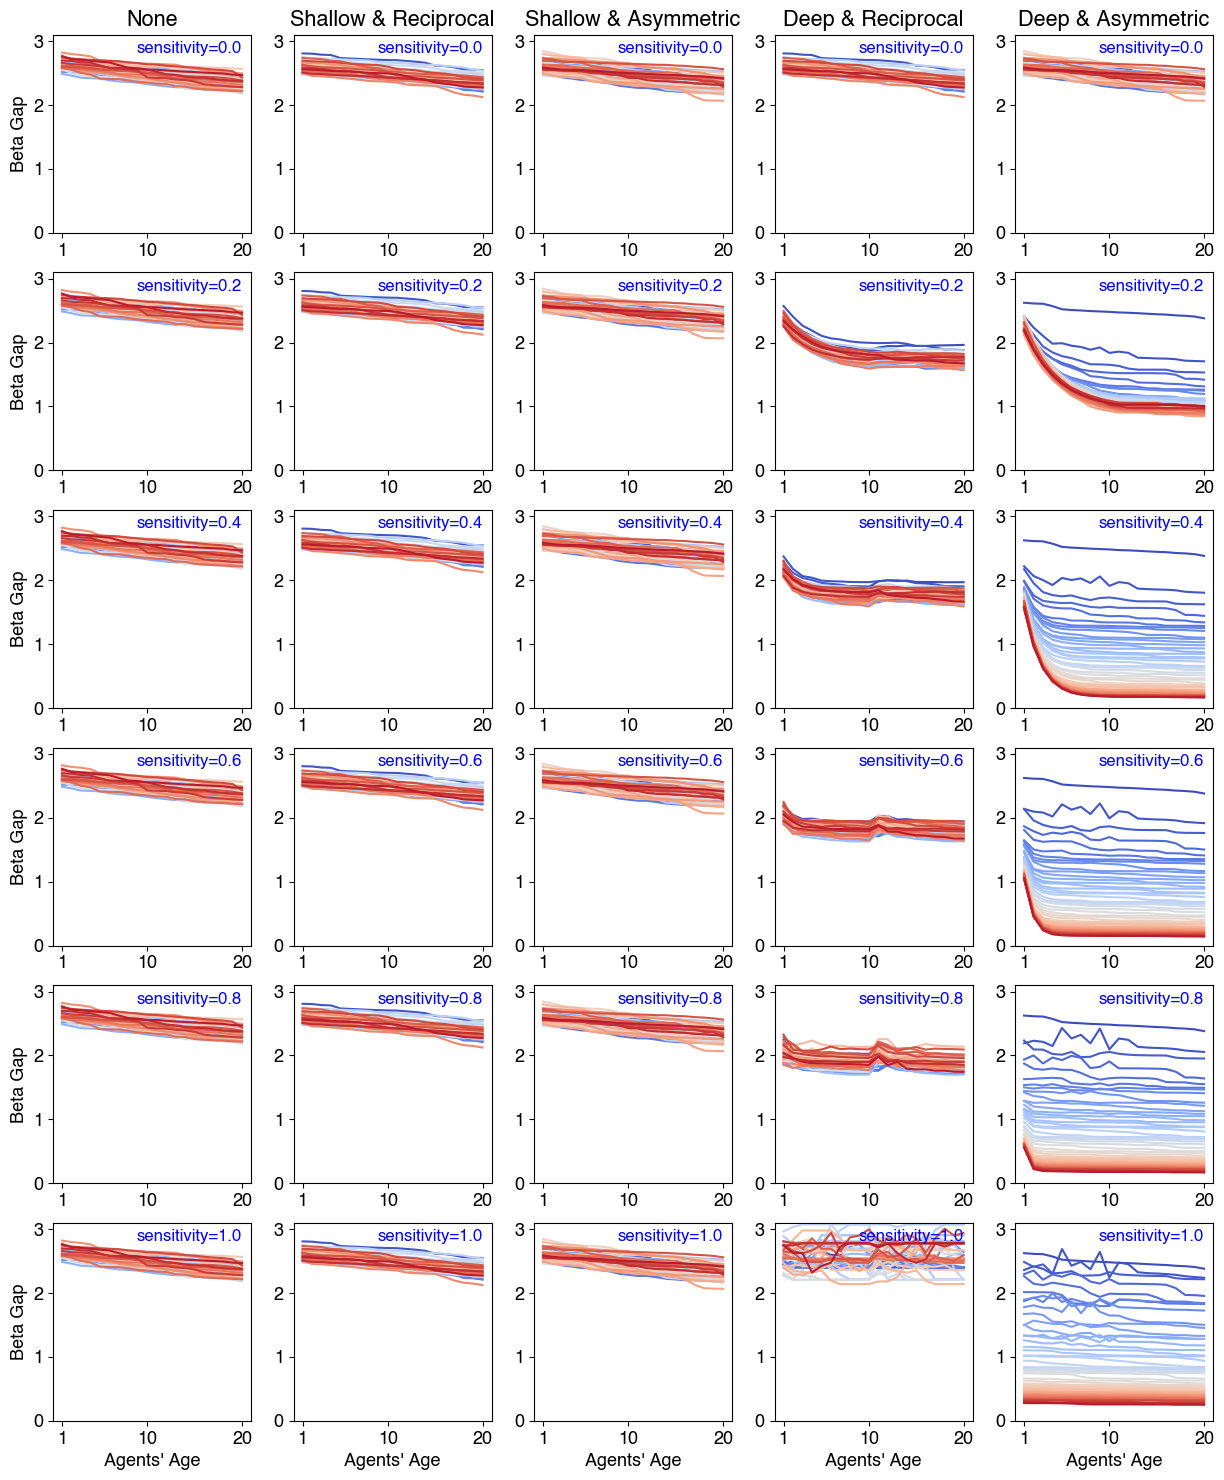

In [101]:
sens = sensitivity_analysis('sensitivity', np.arange(0, 1.1, .2))
plot_sensitivity_analysis(sens)


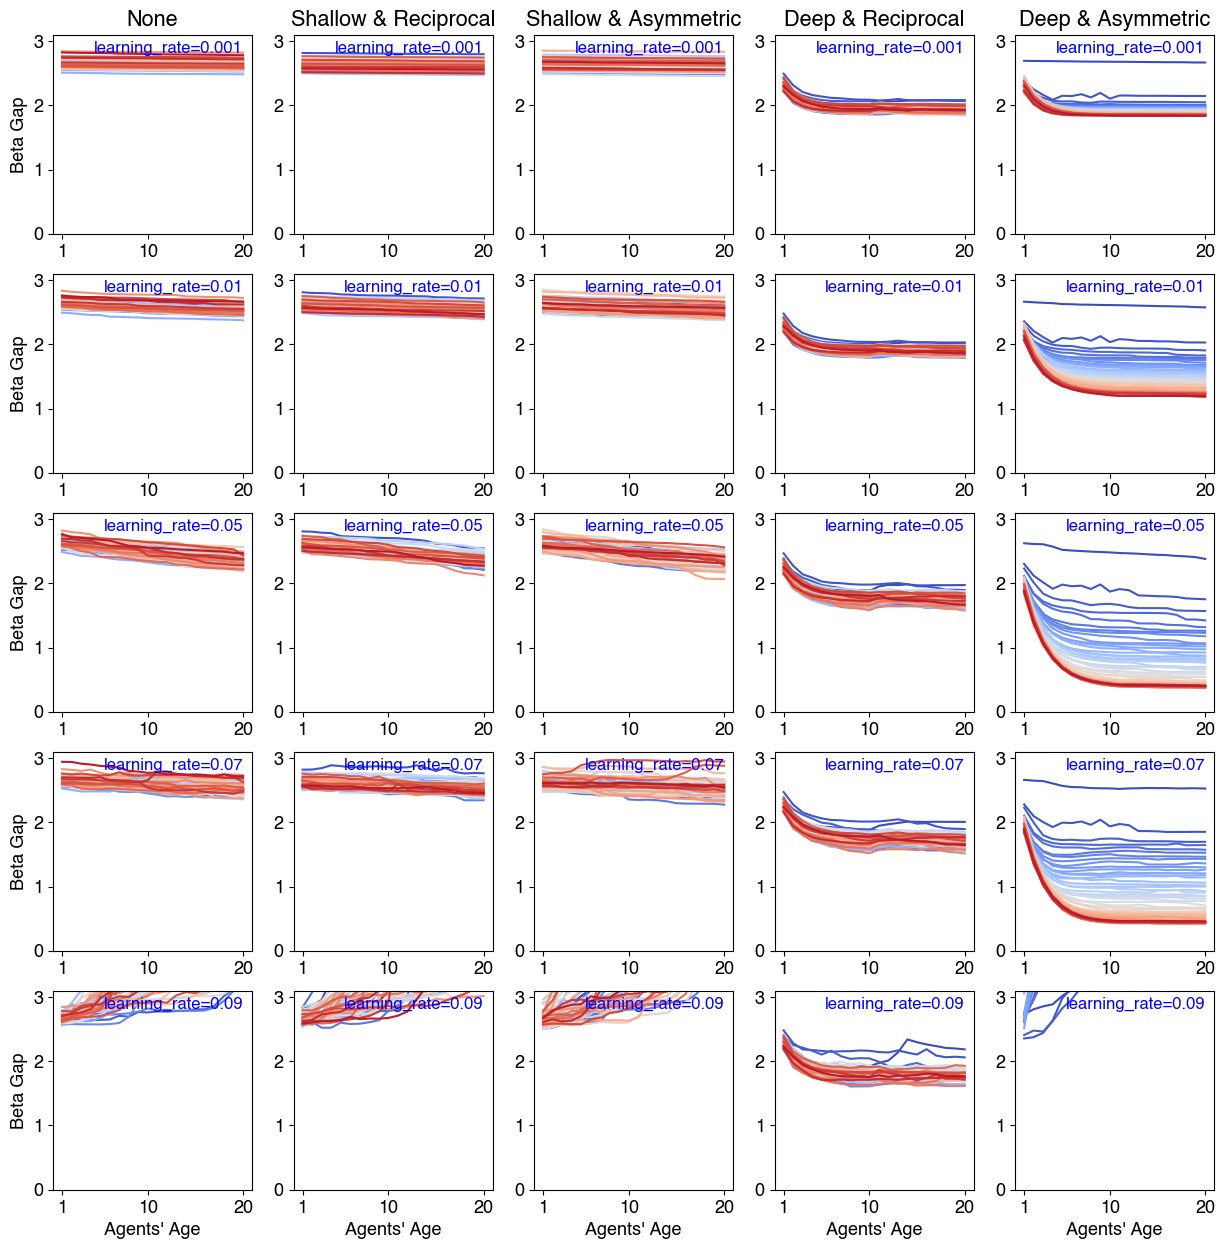

In [100]:
leaning_rate = sensitivity_analysis('learning_rate', [.001, .01, .05, .07, .09])
plot_sensitivity_analysis(leaning_rate)


## Analysis

In [38]:
exp_df = pd.read_csv("./data/main.csv")
exp_df

,Unnamed: 0,participantId,condition,phase,trial,estimate,questionId,label,area,distance,age,socialInfo,rentTruth,manipulationCheck,residentialExperience,gender,participantAge
0,0,dhps19hah2f4fzq,novice,1,1,12.4,20,ジャスミンガーデンズ東大前,14.7,8,19,12.6,10.1,4,3,female,21
1,1,dhps19hah2f4fzq,novice,1,2,9.0,1,ファイブスター後楽園,8.7,2,44,6.6,6.0,4,3,female,21
2,2,dhps19hah2f4fzq,novice,1,3,9.2,4,レジデンス三葉,13.0,5,33,10.0,7.5,4,3,female,21
3,3,dhps19hah2f4fzq,novice,1,4,16.3,2,さくらヒルズレジデンス,21.3,5,19,15.9,14.5,4,3,female,21
4,4,dhps19hah2f4fzq,novice,1,5,10.9,15,あじさいテラス,15.1,5,19,12.9,12.0,4,3,female,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2635,52v6dzcjbqdbsuj,expert,3,20,8.3,16,ハイランド竹澤,16.1,2,22,13.2,11.1,4,1,male,21
2576,2636,52v6dzcjbqdbsuj,expert,3,21,10.3,2,センチュリーMINERVA,21.3,5,19,15.9,14.5,4,1,male,21
2577,2637,52v6dzcjbqdbsuj,expert,3,22,8.8,15,ライフホームVIBRANT,15.1,5,19,12.9,12.0,4,1,male,21
2578,2638,52v6dzcjbqdbsuj,expert,3,23,7.8,4,ソレイユ豊川,13.0,5,33,10.0,7.5,4,1,male,21


In [39]:
p_info_df = (
    exp_df[['participantId', 'condition', 'manipulationCheck', 'residentialExperience', 'gender', 'participantAge']].drop_duplicates()
    .reset_index(drop=True)
)
p_info_df['manipulationCheck'] = -p_info_df['manipulationCheck'] + 7
p_info_df

,participantId,condition,manipulationCheck,residentialExperience,gender,participantAge
0,dhps19hah2f4fzq,novice,3,3,female,21
1,6h3k3qqw18ykdvq,expert,5,3,male,20
2,97sgehrgpnmx2a6,expert,2,1,male,20
3,xo490ppnf2uv9z8,novice,2,2,male,21
4,zppb9orx9ku5w02,expert,4,3,male,20
5,jo21djrzccfwu86,novice,5,3,female,19
6,aptrln8nm39ojr1,novice,3,3,male,20
7,pqd2cvk67xeeo0j,novice,5,3,female,20
8,hfofcmkoqfgyeox,expert,4,1,male,20
9,ao6fzojcsy7shek,novice,5,3,male,20


In [40]:
p_info_df.gender.value_counts()

gender
male      26
female    17
Name: count, dtype: int64

In [41]:
p_info_df.participantAge.describe()

count    43.000000
mean     20.279070
std       0.881708
min      19.000000
25%      20.000000
50%      20.000000
75%      21.000000
max      23.000000
Name: participantAge, dtype: float64

In [42]:
pivot_df = (
    exp_df.pivot_table(index=['participantId', 'condition', 'questionId'], columns='phase', values='estimate')
    .rename(columns={1: "first_estimate", 2: "social_prediction", 3: "second_estimate"})
    .reset_index()
)

q_info_df = (
    exp_df[['questionId', 'area', 'distance', 'age', 'socialInfo', 'rentTruth']].drop_duplicates()
    .sort_values('questionId')
    .reset_index(drop=True)
)

pivot_df.columns.name = None
pivot_df['isin_social'] = pivot_df['social_prediction'].notna()
pivot_df = pivot_df.merge(q_info_df, on="questionId")
pivot_df['advice_gap'] = pivot_df['socialInfo'] - pivot_df['first_estimate']
pivot_df['sensitivity'] = pivot_df.apply(lambda x: (x.second_estimate - x.first_estimate) / x.advice_gap if x.advice_gap != 0 else np.nan, axis=1)
pivot_df = pivot_df[lambda x: x.sensitivity.between(-1, 2, inclusive='both')]
pivot_df

,participantId,condition,questionId,first_estimate,social_prediction,second_estimate,isin_social,area,distance,age,socialInfo,rentTruth,advice_gap,sensitivity
0,1p3u2kc8wqgyeb8,expert,0,10.5,11.0,10.5,True,7.3,5,18,9.3,5.9,-1.2,-0.000000
1,24ajbskdttx5eeo,expert,0,10.5,12.0,9.5,True,7.3,5,18,9.3,5.9,-1.2,0.833333
2,2gco68qpnnscppe,expert,0,10.5,11.2,10.0,True,7.3,5,18,9.3,5.9,-1.2,0.416667
3,4r2ylq5yd4tsfsp,novice,0,7.9,NaN,7.6,False,7.3,5,18,9.3,5.9,1.4,-0.214286
4,52v6dzcjbqdbsuj,expert,0,6.3,7.6,6.3,True,7.3,5,18,9.3,5.9,3.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,xo490ppnf2uv9z8,novice,23,12.0,9.4,8.0,True,12.3,6,52,7.0,6.9,-5.0,0.800000
1028,y38uuupsmb6q398,novice,23,7.3,7.2,7.1,True,12.3,6,52,7.0,6.9,-0.3,0.666667
1029,yrhu178xydh1ndt,novice,23,8.3,NaN,8.3,False,12.3,6,52,7.0,6.9,-1.3,-0.000000
1030,z0qlcw250l6a111,novice,23,8.0,8.0,7.5,True,12.3,6,52,7.0,6.9,-1.0,0.500000


In [43]:
agg_pivot_df = (
    pivot_df
    .groupby(['participantId', 'condition', 'isin_social'])['sensitivity'].agg(['mean', 'count']).reset_index()
    .merge(p_info_df, on='participantId')
)
agg_pivot_df

,participantId,condition_x,isin_social,mean,count,condition_y,manipulationCheck,residentialExperience,gender,participantAge
0,1p3u2kc8wqgyeb8,expert,False,0.222124,9,expert,4,3,male,22
1,1p3u2kc8wqgyeb8,expert,True,0.497389,11,expert,4,3,male,22
2,24ajbskdttx5eeo,expert,False,0.497780,12,expert,4,2,female,20
3,24ajbskdttx5eeo,expert,True,0.571252,12,expert,4,2,female,20
4,2gco68qpnnscppe,expert,False,0.368155,8,expert,2,2,male,20
...,...,...,...,...,...,...,...,...,...,...
81,yrhu178xydh1ndt,novice,True,0.416200,12,novice,2,2,male,22
82,z0qlcw250l6a111,novice,False,0.196043,12,novice,3,3,female,21
83,z0qlcw250l6a111,novice,True,0.395240,12,novice,3,3,female,21
84,zppb9orx9ku5w02,expert,False,0.555357,11,expert,4,3,male,20


## Figure 3:    


    False
        slope: 0.10580953704575603
        intercept: 0.11898278489008413
        p: 0.004220229300891779
        r: 0.4277499292707185
    

    True
        slope: 0.10022556583499108
        intercept: 0.20124609383223213
        p: 0.00014814713865508975
        r: 0.5468365602698441
    


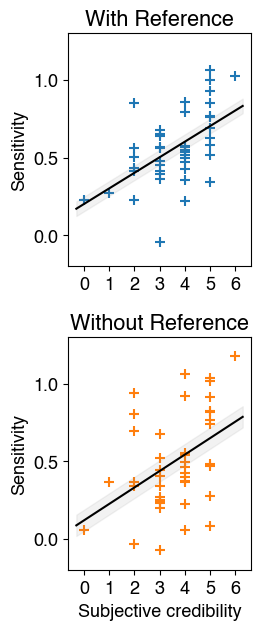

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(2.8, 6.5))
for isin_social, data in agg_pivot_df.groupby("isin_social"):
    i = 0 if isin_social else 1
    ax = axes[i]
    x = data['manipulationCheck']
    y = data['mean']
    ax.scatter(x, y, marker="+", s=60, color=f"C{i}")#, fc='w', alpha=.9)
    # ax.scatter(x, y, marker="o", s=70, color=f"C{i}", alpha=data['count']/12, fc="w")
    ax.set_ylim(-.2, 1.3)
    ax.set_title("With Reference" if isin_social else "Without Reference")
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f"""
    {isin_social}
        slope: {slope}
        intercept: {intercept}
        p: {p_value}
        r: {r_value}
    """)
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '-', color='k')
    ci = 1.96 * std_err
    ax.fill_between(x_vals, y_vals - ci, y_vals + ci, color='grey', alpha=0.1)
    ax.set_yticks([0, .5, 1])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.set_ylabel("Sensitivity")
    if not isin_social:
        ax.set_xlabel("Subjective credibility")


plt.tight_layout()
# plt.savefig("img/fig4b.pdf")
plt.show()
plt.close()

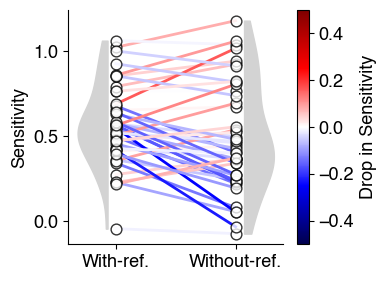

In [48]:
mean_sensitivity = (
    pivot_df
    .pivot_table(index=["participantId"], columns=["isin_social"], values="sensitivity", aggfunc="mean")
)

per_participant_df = (
    pivot_df.pivot_table(index="participantId", columns="isin_social", values='sensitivity', aggfunc='mean')
    .join(p_info_df.set_index('participantId')['condition'])
)[[True, False, "condition"]]

cmap = plt.cm.seismic
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

for pid, pid_data in mean_sensitivity.iterrows():
    slope = pid_data[False] - pid_data[True]
    # color = "C0" if slope else "C1"
    color = cmap((slope + 1) / 2)
    ax.plot([0, 1], [pid_data[True], pid_data[False]], color=color, lw=2, zorder=0)
    ax.scatter([0], [pid_data[True]], marker="o", fc="w", color="k", s=60, zorder=1, alpha=.8)
    ax.scatter([1], [pid_data[False]], marker="o", fc="w", color="k", s=60, zorder=2, alpha=.8)

v1 = ax.violinplot(
    [mean_sensitivity[True], mean_sensitivity[False]], positions=[-.07, 1.07],
    showmeans=False, showextrema=False, showmedians=False
)

for i, b in enumerate(v1['bodies']):
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    if i == 0:
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    else:
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('lightgrey')
    b.set_alpha(1)
    b.set_edgecolor("lightgrey")

    
ax.set_yticks([0, .5, 1])
ax.set_xticks([0, 1])
ax.set_xticklabels(["With-ref.", "Without-ref."])
ax.set_xlim(-.4, 1.4)
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel("Sensitivity")
# Color bar
norm = matplotlib.colors.Normalize(vmin=-.5, vmax=.5)
scalar_mappable = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(scalar_mappable, ax=ax)
cbar.set_label('Drop in Sensitivity')

plt.tight_layout()
# plt.savefig("img/fig4c.pdf")
plt.show()
plt.close()

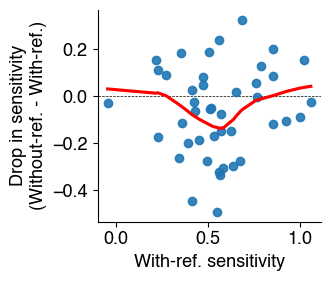

In [46]:
per_participant_df.rename(columns={True: 's_with', False: 's_without'}, inplace=True)
per_participant_df['s_gap'] = per_participant_df['s_without'] - per_participant_df['s_with']

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
ax.spines[['top', 'right']].set_visible(False)
sns.regplot(
    x='s_with', y='s_gap', data=per_participant_df, lowess=True, ax=ax,
    scatter_kws={"color": "C0", 'alpha': .9}, line_kws={"color": "red"}
)
ax.axhline(0, color="k", ls="--", zorder=0, lw=.5)
plt.xlabel('With-ref. sensitivity')
plt.ylabel('Drop in sensitivity\n(Without-ref. - With-ref.)')
plt.xticks([0, .5, 1])
plt.tight_layout()
# plt.savefig("img/fig4d.pdf")
plt.show()
plt.close()


## Stats

In [51]:
d = pivot_df.copy()
d["condition"] = d["condition"].map({"novice": 0, "expert": 1})
d["isin_social"] = d["isin_social"].map({True: 1, False: 0})
d = d[d.sensitivity.between(-1, 2, inclusive="both")]
d["interaction_term"] = d["isin_social"] * d["condition"]
d["intercept"] = 1

Y = d["sensitivity"].values
X = d[["isin_social", "condition", "interaction_term", "intercept"]].values
Group = d[["questionId", "participantId"]].values

model = gpb.GPModel(group_data=Group, likelihood="gaussian")
model.fit(y=Y, X=X, params={"std_dev": True})
model.summary()
model.get_coef()


Model summary:
 Log-lik     AIC     BIC
 -600.56 1215.12 1249.01
Nb. observations: 936
Nb. groups: 24 (Group_1), 43 (Group_2)
-----------------------------------------------------
Covariance parameters (random effects):
            Param.  Std. dev.
Error_term  0.1915     0.0092
Group_1     0.0015     0.0019
Group_2     0.0558     0.0140
-----------------------------------------------------
Linear regression coefficients (fixed effects):
             Param.  Std. dev.  z value  P(>|z|)
Covariate_1  0.0804     0.0392   2.0508   0.0403
Covariate_2  0.0681     0.0835   0.8158   0.4146
Covariate_3 -0.0437     0.0578  -0.7567   0.4492
Covariate_4  0.4697     0.0575   8.1725   0.0000


,Covariate_1,Covariate_2,Covariate_3,Covariate_4
Param.,0.080438,0.068140,-0.043705,0.469744
Std. dev.,0.039223,0.083529,0.057760,0.057478


In [52]:
cred_high = p_info_df.query('condition == "expert"').manipulationCheck.values
cred_low = p_info_df.query('condition == "novice"').manipulationCheck.values

print(pd.DataFrame(pd.Series(cred_high.ravel()).describe()).transpose())
print(pd.DataFrame(pd.Series(cred_low.ravel()).describe()).transpose())

ttest_ind(cred_high, cred_low, equal_var=False)


   count  mean       std  min  25%  50%  75%  max
0   20.0   3.8  1.056309  2.0  3.0  4.0  5.0  5.0
   count      mean      std  min  25%  50%  75%  max
0   23.0  3.434783  1.44052  0.0  3.0  3.0  4.5  6.0


Ttest_indResult(statistic=0.9557810651826022, pvalue=0.344932808069207)

In [54]:
d = pivot_df.merge(p_info_df.drop("condition", axis=1), on="participantId")
d["condition"] = d["condition"].map({"novice": 0, "expert": 1})
d["isin_social"] = d["isin_social"].map({True: 1, False: 0})
d["manipulationCheck"] = (d["manipulationCheck"] - np.mean(d["manipulationCheck"])) / np.std(d["manipulationCheck"])
d = d[d.sensitivity.between(-1, 2, inclusive="both")]
d["interaction_term"] = d["isin_social"] * d["manipulationCheck"]
d["intercept"] = 1

Y = d["sensitivity"].values
X = d[["isin_social", "manipulationCheck", "interaction_term", "intercept"]].values
Group = d[["questionId", "participantId"]].values

model = gpb.GPModel(group_data=Group, likelihood="gaussian")
model.fit(y=Y, X=X, params={"std_dev": True})
model.summary()
model.get_coef()


Model summary:
 Log-lik     AIC     BIC
 -594.15 1202.29 1236.18
Nb. observations: 936
Nb. groups: 24 (Group_1), 43 (Group_2)
-----------------------------------------------------
Covariance parameters (random effects):
            Param.  Std. dev.
Error_term  0.1916     0.0092
Group_1     0.0015     0.0019
Group_2     0.0388     0.0103
-----------------------------------------------------
Linear regression coefficients (fixed effects):
             Param.  Std. dev.  z value  P(>|z|)
Covariate_1  0.0609     0.0288   2.1122   0.0347
Covariate_2  0.1412     0.0368   3.8332   0.0001
Covariate_3 -0.0144     0.0288  -0.4988   0.6179
Covariate_4  0.5000     0.0374  13.3536   0.0000


,Covariate_1,Covariate_2,Covariate_3,Covariate_4
Param.,0.060901,0.141187,-0.014383,0.500039
Std. dev.,0.028832,0.036833,0.028834,0.037446


In [53]:
d = mean_sensitivity.reset_index().rename(columns={True: "sensitivity_with", False: "sensitivity_without"})
sensitivity_with = d.sensitivity_with.values
sensitivity_without = d.sensitivity_without.values

cor, p = spearmanr(sensitivity_with, sensitivity_without)

print("Spearman's correlation coefficient: {:.3f}".format(cor))
print("p-value: {:.3f}".format(p))


Spearman's correlation coefficient: 0.721
p-value: 0.000
